# Sanity checks for the dataloader
S.Rasp developed the dataloader, the pytorch tool to wrap all the data laoding, preparation and batch generation... 


**Special focus should be given on th patches and times**

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs
# add src directory
import sys
sys.path.append('..')
from src.dataloader import *

## General functionality of data loader

In [12]:
ds = TiggeMRMSDataset(
    tigge_dir='/datadrive/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    val_days=7,
    split='train',
    tp_log=1
) 

In [165]:
print(ds)
idx= 1200 # which patch index to use
X, y = ds[idx] # X: tigge, y : radar


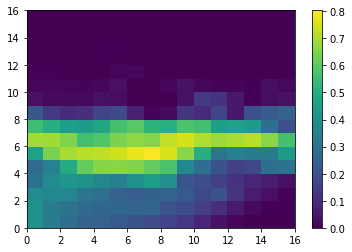

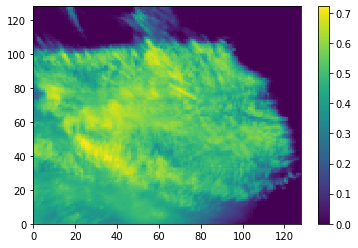

In [315]:
plt.pcolor(X[0]) 
plt.colorbar()
plt.figure()
plt.pcolor(y[0])
plt.colorbar()


## Check TIGGE data

In [121]:
tigge_tp = xr.open_mfdataset('/datadrive/tigge/32km/total_precipitation/*.nc').tp.diff('lead_time')
tigge_tp

<xarray.DataArray 'tp' (init_time: 825, lead_time: 8, lat: 93, lon: 172)>
dask.array<sub, shape=(825, 8, 93, 172), dtype=float32, chunksize=(62, 8, 93, 172), chunktype=numpy.ndarray>
Coordinates:
  * init_time  (init_time) datetime64[ns] 2019-10-01 ... 2020-11-30T12:00:00
  * lead_time  (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
  * lon        (lon) float64 235.2 235.5 235.8 236.2 ... 289.0 289.3 289.6 289.9
  * lat        (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24

In [155]:
tigge_tp.

<xarray.DataArray 'lead_time' (lead_time: 8)>
array([ 21600000000000,  43200000000000,  64800000000000,  86400000000000,
       108000000000000, 129600000000000, 151200000000000, 172800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
Attributes:
    long_name:  Forecast offset from initial time

### Compare Time steps: 
the time-idx value corresponds to the time given by the overlap_times array. Note that the leadtime needs to be subtracted. Given the different precip scalings, the two images are similar!  --> Time seems to be alright between manually loaded and ds.tigge data 

In [422]:
idx= 3140 # which patch index to use

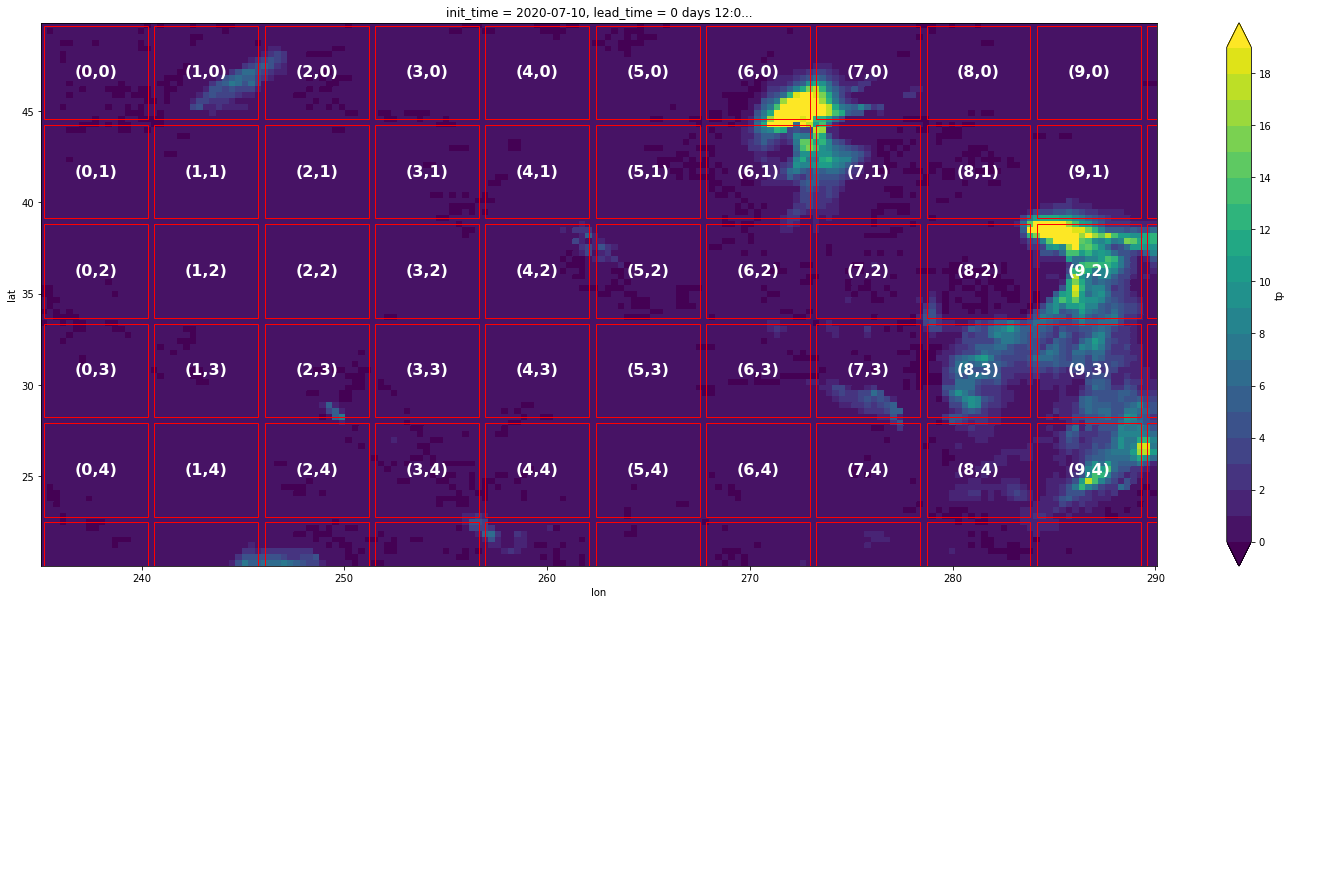

In [474]:
from  matplotlib.patches import Rectangle
tigge_sel = tigge_tp.sel(lead_time=np.timedelta64(12, 'h'))
t_idx, lat_idx, lon_idx = ds.idxs[idx] # take indices from selected patch idx

fig = plt.figure(figsize=[25,10])
tigge_sel  = tigge_sel.sel(init_time=ds.overlap_times[t_idx] - np.timedelta64(12, 'h'))
tigge_sel.plot(cmap='viridis', levels=np.arange(0,20))

patch_lat = tigge_sel.lat.max().values+0.32
patch_lon = tigge_sel.lon.min().values

# Create  Rectangle patches
delta = ds.patch_size/100 # patch size in deg
for i in range(0,12):
    for j in range(0,9):
        xy = np.array((patch_lon+i*(delta+0.32),patch_lat-(j+1)*(delta+0.32)))
        rect = Rectangle(xy ,delta, delta , linewidth=1,edgecolor='r',facecolor='none')
        fig.gca().add_patch(rect)
        fig.gca().annotate('(%i,%i)'%(i,j), xy+delta/2, color='w', weight='bold', 
                fontsize=16, ha='center', va='center')

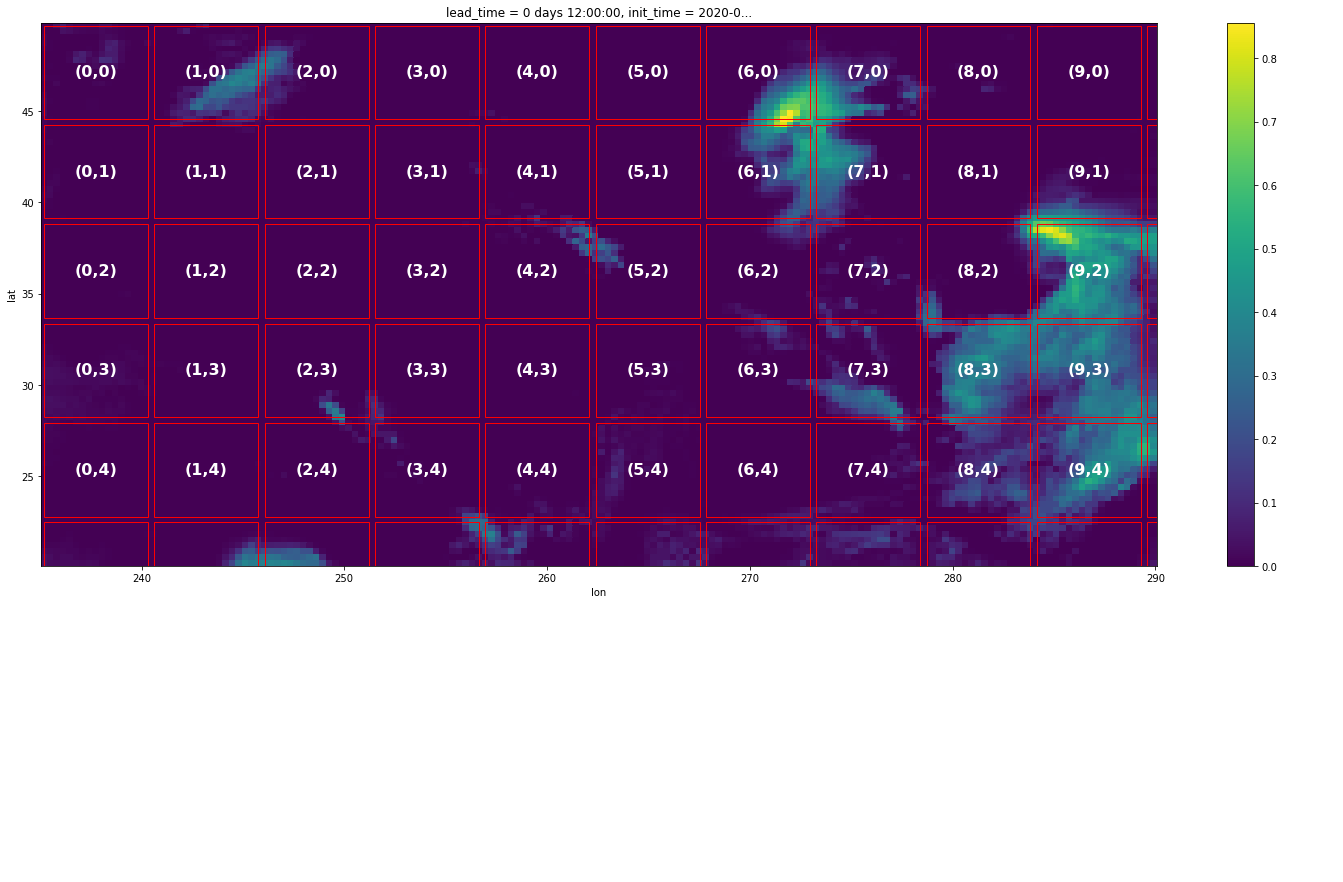

In [476]:
from  matplotlib.patches import Rectangle
fig = plt.figure(figsize=[25,10])
ds.tigge.isel(valid_time=t_idx,variable=0).plot()

patch_lat = tigge_sel.lat.max().values +0.32
patch_lon = tigge_sel.lon.min().values

# Create  Rectangle patches
delta = ds.patch_size/100 # patch size in deg
for i in range(0,12):
    for j in range(0,9):
        xy = np.array((patch_lon+i*(delta+0.32),patch_lat-(j+1)*(delta+0.32)))
        rect = Rectangle(xy ,delta, +delta , linewidth=1,edgecolor='r',facecolor='none')
        fig.gca().add_patch(rect)
        fig.gca().annotate('(%i,%i)'%(i,j), xy+delta/2, color='w', weight='bold', 
                fontsize=16, ha='center', va='center')

### Now compare ds.tigge with ds[patch_idx]

In [431]:
idx= 3590 # which patch index to use

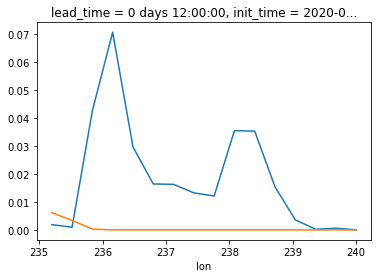

In [589]:
test = ds.tigge.isel(
    valid_time=t_idx,
    lat=slice(0 * ds.patch_tigge, (0+1) * ds.patch_tigge + ds.pad_tigge*2),
    lon=slice(0 * ds.patch_tigge, (0+1) * ds.patch_tigge + ds.pad_tigge*2)
)
test.isel(lat=0).plot()
test = ds.tigge.isel(
    valid_time=t_idx,
    lat=slice(1 * ds.patch_tigge, (1+1) * ds.patch_tigge + ds.pad_tigge*2),
    lon=slice(0 * ds.patch_tigge, (0+1) * ds.patch_tigge + ds.pad_tigge*2)
)

test.isel(lat=-1).plot()

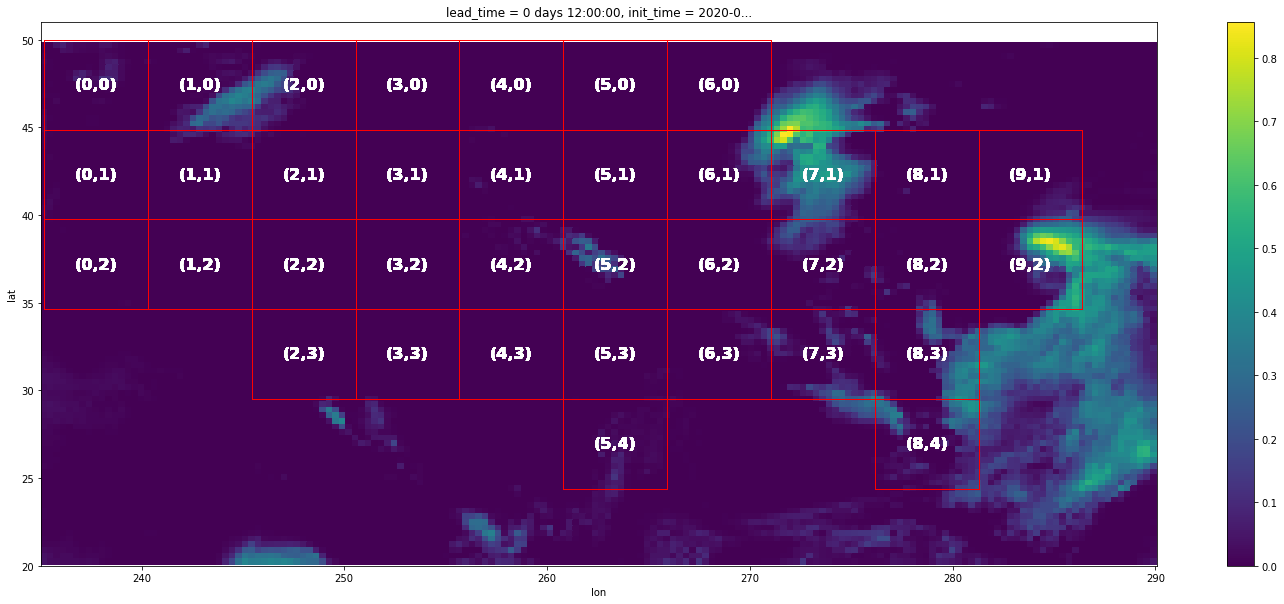

In [569]:
from  matplotlib.patches import Rectangle
fig = plt.figure(figsize=[25,10])
t_idx, lat_idx, lon_idx = ds.idxs[idx] # take indices from selected patch idx

ds.tigge.isel(valid_time=t_idx,variable=0).plot()

patch_lat = tigge_sel.lat.max().values+0.32
patch_lon = tigge_sel.lon.min().values

# Create  Rectangle patches
delta = ds.patch_size/100 # patch size in deg
for lat_idx,lon_idx in ds.idxs[:,1:3]:
        test = ds.tigge.isel(
            valid_time=t_idx,
            lat=slice(lat_idx * ds.patch_tigge, (lat_idx+1) * ds.patch_tigge + ds.pad_tigge*2),
            lon=slice(lon_idx * ds.patch_tigge, (lon_idx+1) * ds.patch_tigge + ds.pad_tigge*2)
        )

        #print(j)
        #print(test.lat.max('lat').values)
        xy = np.array([test.lon.min('lon'),test.lat.min('lat').values])
        rect = Rectangle(xy ,delta, delta , linewidth=1,edgecolor='r',facecolor='none')
        fig.gca().add_patch(rect)
        fig.gca().annotate('(%i,%i)'%(lon_idx,lat_idx), xy+delta/2, color='w', weight='bold', 
                fontsize=16, ha='center', va='center')
        plt.ylim([20,51])



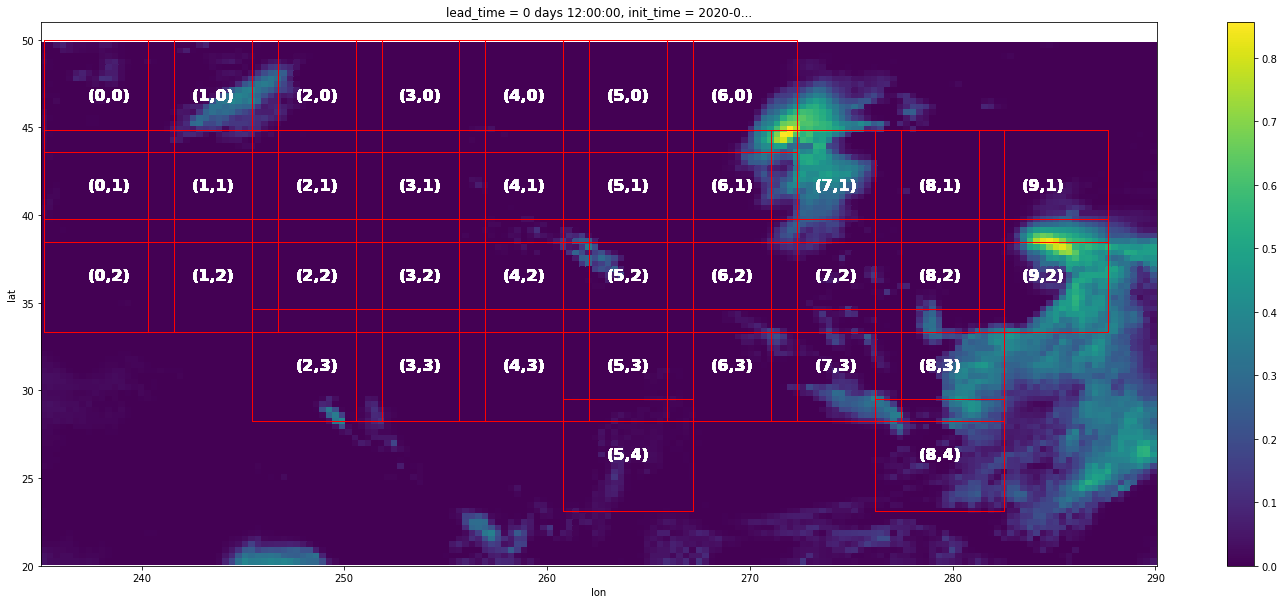

In [598]:
from  matplotlib.patches import Rectangle
fig = plt.figure(figsize=[25,10])
t_idx, lat_idx, lon_idx = ds.idxs[idx] # take indices from selected patch idx

ds.tigge.isel(valid_time=t_idx,variable=0).plot()

patch_lat = tigge_sel.lat.max().values+0.32
patch_lon = tigge_sel.lon.min().values

pad_tigge = 2
# Create  Rectangle patches
delta = ds.patch_size/100 +pad_tigge*2*0.32 # patch size in deg
for lat_idx,lon_idx in ds.idxs[:,1:3]:
        test = ds.tigge.isel(
            valid_time=t_idx,
            lat=slice(lat_idx * ds.patch_tigge, (lat_idx+1) * ds.patch_tigge + pad_tigge*2),
            lon=slice(lon_idx * ds.patch_tigge, (lon_idx+1) * ds.patch_tigge + pad_tigge*2)
        )

        #print(j)
        #print(test.lat.max('lat').values)
        xy = np.array([test.lon.min('lon'),test.lat.min('lat').values])
        rect = Rectangle(xy ,delta, delta, linewidth=1,edgecolor='r',facecolor='none')
        fig.gca().add_patch(rect)
        fig.gca().annotate('(%i,%i)'%(lon_idx,lat_idx), xy+delta/2, color='w', weight='bold', 
                fontsize=16, ha='center', va='center')
        plt.ylim([20,51])



[235.2   44.88]
[235.2   39.76]
[235.2   34.64]
[235.2   29.52]
[235.2  24.4]
[240.32  44.88]
[240.32  39.76]
[240.32  34.64]
[240.32  29.52]
[240.32  24.4 ]
[245.44  44.88]
[245.44  39.76]
[245.44  34.64]
[245.44  29.52]
[245.44  24.4 ]
[250.56  44.88]
[250.56  39.76]
[250.56  34.64]
[250.56  29.52]
[250.56  24.4 ]
[255.68  44.88]
[255.68  39.76]
[255.68  34.64]
[255.68  29.52]
[255.68  24.4 ]
[260.8   44.88]
[260.8   39.76]
[260.8   34.64]
[260.8   29.52]
[260.8  24.4]
[265.92  44.88]
[265.92  39.76]
[265.92  34.64]
[265.92  29.52]
[265.92  24.4 ]
[271.04  44.88]
[271.04  39.76]
[271.04  34.64]
[271.04  29.52]
[271.04  24.4 ]
[276.16  44.88]
[276.16  39.76]
[276.16  34.64]
[276.16  29.52]
[276.16  24.4 ]
[281.28  44.88]
[281.28  39.76]
[281.28  34.64]
[281.28  29.52]
[281.28  24.4 ]


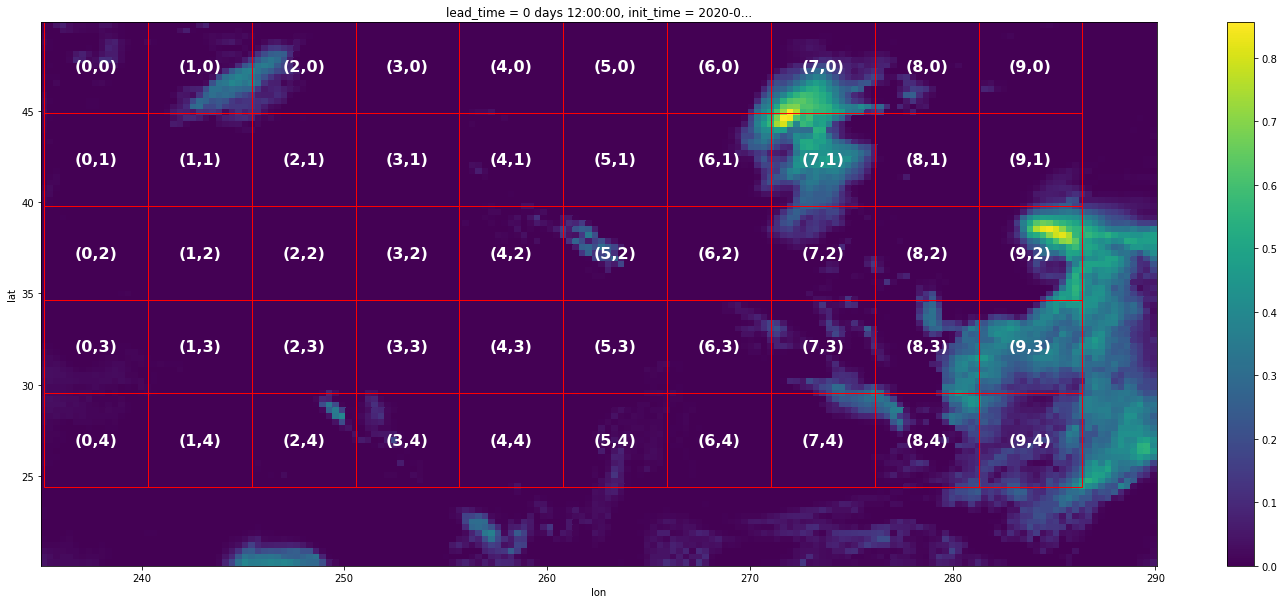

In [551]:
from  matplotlib.patches import Rectangle
fig = plt.figure(figsize=[25,10])
t_idx, lat_idx, lon_idx = ds.idxs[idx] # take indices from selected patch idx

ds.tigge.isel(valid_time=t_idx,variable=0).plot()

patch_lat = tigge_sel.lat.max().values+0.32
patch_lon = tigge_sel.lon.min().values

# Create  Rectangle patches
delta = ds.patch_size/100 # patch size in deg
for i in range(0,10):
    for j in range(0,5):
        test = ds.tigge.isel(
            valid_time=t_idx,
            lat=slice(j * ds.patch_tigge, (j+1) * ds.patch_tigge + ds.pad_tigge*2),
            lon=slice(i * ds.patch_tigge, (i+1) * ds.patch_tigge + ds.pad_tigge*2)
        )

        #print(j)
        #print(test.lat.max('lat').values)
        xy = np.array([test.lon.min('lon'),test.lat.min('lat').values])
        print(xy)
        rect = Rectangle(xy ,delta, delta , linewidth=1,edgecolor='r',facecolor='none')
        fig.gca().add_patch(rect)
        fig.gca().annotate('(%i,%i)'%(i,j), xy+delta/2, color='w', weight='bold', 
                fontsize=16, ha='center', va='center')



In [535]:
np.array([test.lon.min('lon'),test.lat.min('lat').values])[0]

235.20000000000002

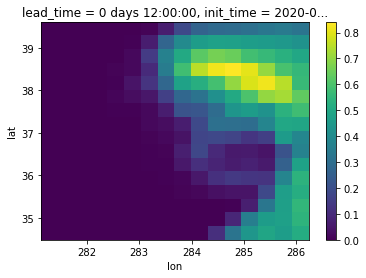

In [486]:
test = ds.tigge.isel(
            valid_time=t_idx,
            lat=slice(j * ds.patch_tigge, (j+1) * ds.patch_tigge + ds.pad_tigge*2),
            lon=slice(i * ds.patch_tigge, (i+1) * ds.patch_tigge + ds.pad_tigge*2)
        )
test.plot()

In [485]:
ds.        xy = np.array((test.lon.min('lon').values), test.lat.min('lat').values)

16

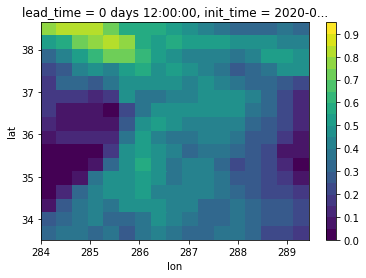

In [478]:
test = ds.tigge.isel(valid_time=t_idx,variable=0).sel(lon=slice(xy[0],xy[0]+delta), lat = slice(xy[1]+delta, xy[1]))
test.plot(levels=np.arange(0,1,.05))

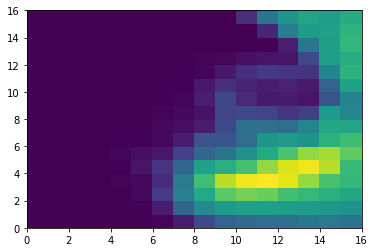

In [479]:
X,_ = ds[idx]
plt.pcolor(X[0])


In [448]:
X = ds.tigge.isel(
            valid_time=t_idx,
            lat=slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge + self.pad_tigge*2),
            lon=slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge + self.pad_tigge*2)
        ).values

16.0

In [452]:
tigge_tp

<xarray.DataArray 'tp' (init_time: 825, lead_time: 8, lat: 93, lon: 172)>
dask.array<sub, shape=(825, 8, 93, 172), dtype=float32, chunksize=(62, 8, 93, 172), chunktype=numpy.ndarray>
Coordinates:
  * init_time  (init_time) datetime64[ns] 2019-10-01 ... 2020-11-30T12:00:00
  * lead_time  (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
  * lon        (lon) float64 235.2 235.5 235.8 236.2 ... 289.0 289.3 289.6 289.9
  * lat        (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24

## Check MRMS Radar data

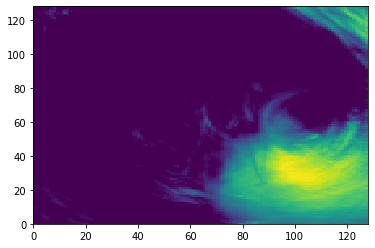

In [616]:
idx=3590
t_idx, lat_idx,lon_idx = ds.idxs[idx]
X,y = ds[idx]
plt.pcolor(y[0])

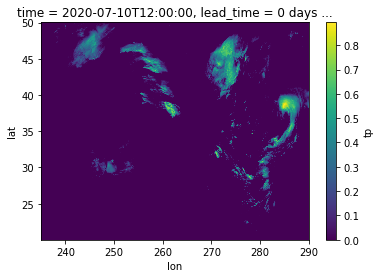

In [609]:
ds.mrms.isel(time=t_idx).plot()

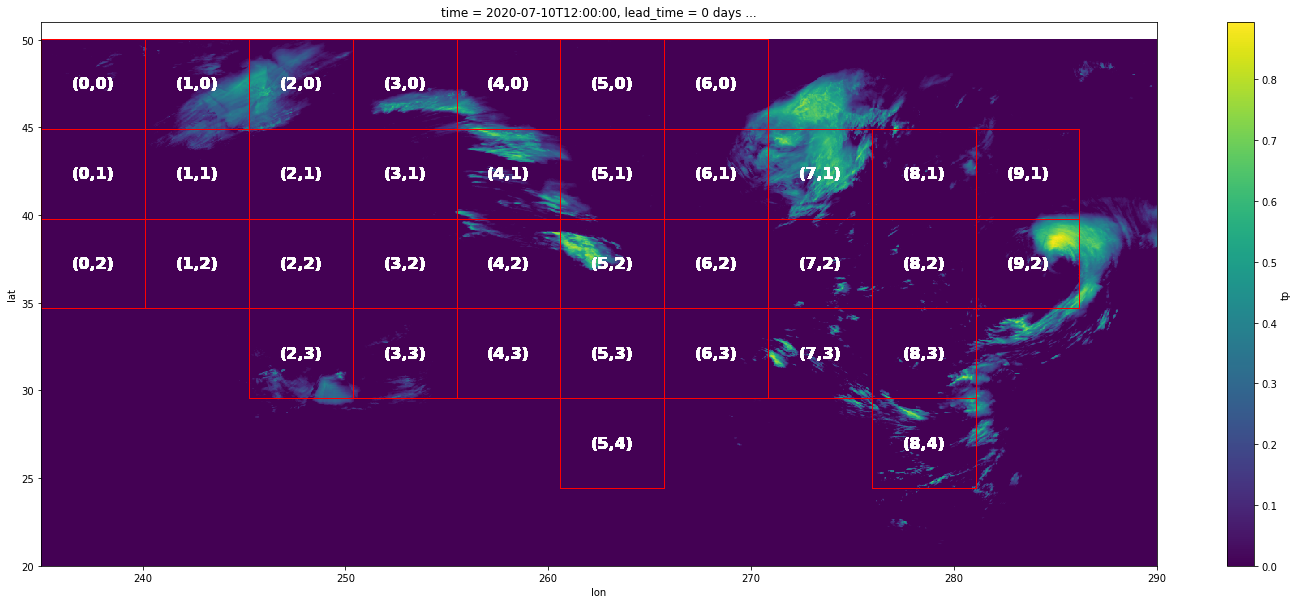

In [613]:
fig = plt.figure(figsize=[25,10])
ds.mrms.isel(time=t_idx).plot()

# Create  Rectangle patches
delta = ds.patch_size/100 # patch size in deg
for lat_idx,lon_idx in ds.idxs[:,1:3]:
        test = ds.mrms.isel(
            time=t_idx,
            lat=slice(lat_idx * ds.patch_mrms, (lat_idx+1) * ds.patch_mrms + ds.pad_mrms*2),
            lon=slice(lon_idx * ds.patch_mrms, (lon_idx+1) * ds.patch_mrms + ds.pad_mrms*2)
        )

        #print(j)
        #print(test.lat.max('lat').values)
        xy = np.array([test.lon.min('lon'),test.lat.min('lat').values])
        rect = Rectangle(xy ,delta, delta , linewidth=1,edgecolor='r',facecolor='none')
        fig.gca().add_patch(rect)
        fig.gca().annotate('(%i,%i)'%(lon_idx,lat_idx), xy+delta/2, color='w', weight='bold', 
                fontsize=16, ha='center', va='center')
        plt.ylim([20,51])



In [617]:
lon_idx

9

In [618]:
lat_idx

2